In [1]:
# Useful packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sage
import seaborn as sns
from collections import Counter, defaultdict
import itertools
import math

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import check_random_state
from sklearn.metrics import brier_score_loss
from sklearn.dummy import DummyClassifier
from scipy.stats import bootstrap


In [2]:
flip_proba = 0.2
n_folds = 5
n_estimators = 100
rng = check_random_state(0)
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "noise 10%", "noise 50%"]
train_sizes_largest = np.logspace(3, 5, 7, dtype=int)
irrelevant = (0.1, 0.5)

# Generating the dataset
We take the led dataset and add noise to it to introduce randomness and compare between train and test sets.

In [3]:
def make_noised_led_sample(
    n_samples=200, irrelevant=None, flip_proba=0.1, random_state=None
):
    random_state = check_random_state(random_state)

    data = np.array(
        [
            [0, 0, 1, 0, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 1, 2],
            [1, 0, 1, 1, 0, 1, 1, 3],
            [0, 1, 1, 1, 0, 1, 0, 4],
            [1, 1, 0, 1, 0, 1, 1, 5],
            [1, 1, 0, 1, 1, 1, 1, 6],
            [1, 0, 1, 0, 0, 1, 0, 7],
            [1, 1, 1, 1, 1, 1, 1, 8],
            [1, 1, 1, 1, 0, 1, 1, 9],
            [1, 1, 1, 0, 1, 1, 1, 0],
        ]
    )

    data = data[random_state.randint(0, 10, n_samples)]
    X, y = np.array(data[:, :7], dtype=np.intp), data[:, 7]
    X_noised = np.zeros_like(X)
    for sample in range(n_samples):
        X_noised[sample, :] = np.abs(
            random_state.binomial(n=1, p=flip_proba, size=7) - X[sample, :]
        )
    if irrelevant:
        for proba in irrelevant:
            X_noised = np.hstack((X_noised, random_state.binomial(n=1, p=proba, size=n_samples)[:, np.newaxis]))
    return X_noised, y


# Compare asymptotics of MDI and UMDI

In [4]:
def get_clean_patterns():
    """Return dict of label → list of clean 7-bit vectors"""
    patterns = np.array([
        [0, 0, 1, 0, 0, 1, 0, 1],
        [1, 0, 1, 1, 1, 0, 1, 2],
        [1, 0, 1, 1, 0, 1, 1, 3],
        [0, 1, 1, 1, 0, 1, 0, 4],
        [1, 1, 0, 1, 0, 1, 1, 5],
        [1, 1, 0, 1, 1, 1, 1, 6],
        [1, 0, 1, 0, 0, 1, 0, 7],
        [1, 1, 1, 1, 1, 1, 1, 8],
        [1, 1, 1, 1, 0, 1, 1, 9],
        [1, 1, 1, 0, 1, 1, 1, 0],
    ])
    label_map = defaultdict(list)
    for row in patterns:
        label_map[int(row[-1])].append(tuple(row[:-1]))
    return label_map

def get_joint_distribution(flip_proba=0.1):
    label_map = get_clean_patterns()
    all_noised = list(itertools.product([0, 1], repeat=7))
    joint = defaultdict(float)
    p = flip_proba

    for y in range(10):
        for x_clean in label_map[y]:
            for x_noised in all_noised:
                prob = 1.0
                for bit_clean, bit_noised in zip(x_clean, x_noised):
                    prob *= p if bit_clean != bit_noised else (1 - p)
                joint[(x_noised, y)] += prob / 10.0  # uniform prior over digits
    return joint  # dict mapping (x_tuple, y) → P(x, y)

def powerset(iterable):
    s = list(iterable)
    return list(itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1)))

def exact_sage_from_joint(joint):
    """
    Given P(x,y) compute for every i & S: 
    v(S U {i}) - v(S) = E_{X_S}[Var(E[1_Y | X_S, X_i] | X_S)]
    = E_{X_S} [ sum_{x_i} P(x_i|X_S) || P(Y | X_S, x_i) - P(Y | X_S) ||^2 ]
    """
    n_classes=10
    d=7
    D = list(range(d))
    all_inputs = list(itertools.product([0, 1], repeat=d))
    Y_vals = list(range(n_classes))

    # Compute P(x)=
    px = defaultdict(float)
    for (x, y), pxy in joint.items():
        px[x] += pxy

    phi = np.zeros(d)
    for i in range(d):
        subsets = list(powerset([j for j in D if j != i]))
        for S in subsets:
            k = len(S)
            weight = math.factorial(k) * math.factorial(d - k - 1) / math.factorial(d - 1)
            xS_groups = defaultdict(list)

            for x in all_inputs:
                xS = tuple(x[j] for j in S)
                xS_groups[xS].append(x)

            total_contrib = 0.0
            for xS, x_fulls in xS_groups.items():
                pxS = 0.0
                prob_y_given_xs = np.zeros(n_classes)
                prob_y_given_xsi = {0: np.zeros(n_classes), 1: np.zeros(n_classes)}
                pxSxi = {0: 0.0, 1: 0.0}

                for x_full in x_fulls:
                    x_i = x_full[i]
                    px_val = px.get(x_full, 0.0)
                    pxS += px_val
                    pxSxi[x_i] += px_val

                    for y in Y_vals:
                        pxy = joint.get((x_full, y), 0.0)
                        prob_y_given_xs[y] += pxy
                        prob_y_given_xsi[x_i][y] += pxy

                if pxS == 0 or pxSxi[0] == 0 or pxSxi[1] == 0:
                    continue

                # Normalize to get probability vectors
                prob_y_given_xs /= pxS
                prob_y_given_xsi[0] /= pxSxi[0]
                prob_y_given_xsi[1] /= pxSxi[1]

                # Compute expected squared L2 difference between P(Y | X_S, X_i) and P(Y | X_S)
                diff0 = prob_y_given_xsi[0] - prob_y_given_xs
                diff1 = prob_y_given_xsi[1] - prob_y_given_xs
                contrib = (
                    pxSxi[0] * np.sum(diff0**2) +
                    pxSxi[1] * np.sum(diff1**2)
                )

                total_contrib += contrib

            phi[i] += weight * total_contrib / d

    return phi


In [5]:
joint = get_joint_distribution(flip_proba=flip_proba)
theoretical_value = exact_sage_from_joint(joint)
theoretical_value = np.concat([theoretical_value, np.zeros_like(irrelevant)])

In [6]:
mdi_large_res = np.zeros((len(train_sizes_largest), n_folds*n_estimators, len(feature_names)))
umdi_large_res = np.zeros((len(train_sizes_largest), n_folds*n_estimators, len(feature_names)))
sage_large_res = np.zeros((len(train_sizes_largest), n_folds, len(feature_names)))
brier_score_improvement = np.zeros((len(train_sizes_largest), n_folds))

for train_size_idx, n_samples in enumerate(train_sizes_largest):
    X, y = make_noised_led_sample(
        n_samples=n_samples, flip_proba=flip_proba, irrelevant=irrelevant, random_state=rng
    )
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=rng)
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        train_size = len(train_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rf = ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_features=1,
            max_depth=None,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=rng,
        )
        rf.fit(X_train, y_train)
        for (tree_idx, tree) in enumerate(rf.estimators_):
            mdi_large_res[train_size_idx, fold*n_estimators + tree_idx, :] = tree._unnormalized_feature_importances

            oob_indices = _generate_unsampled_indices(
                tree.random_state, train_size, train_size
            )
            X_oob = X_train[oob_indices]
            y_oob = y_train[oob_indices]

            umdi_large_res[train_size_idx, fold*n_estimators + tree_idx, :], _ = tree.compute_unbiased_feature_importance(
                X_test=X_oob,
                y_test=y_oob,
            )

        # X_test, y_test = make_noised_led_sample(
        #     n_samples=train_sizes_largest[t_idx], flip_proba=flip_proba, irrelevant=irrelevant, random_state=rng
        # )
        y_test_one_hot = np.eye(10)[y_test]
        imputer = sage.MarginalImputer(rf, X_test[:500])
        estimator = sage.PermutationEstimator(
            imputer, "mse", random_state=rng
        )
        sage_large_res[train_size_idx, fold, :] = estimator(X_test, y_test_one_hot, thresh=0.5, bar=False).values
        dummy = DummyClassifier(random_state=42).fit(X_train, y_train)
        brier_score_improvement[train_size_idx, fold] = brier_score_loss(y_test, dummy.predict_proba(X_test)) - brier_score_loss(y_test, rf.predict_proba(X_test))


In [7]:
mdi_vals = mdi_large_res[train_size_idx, :, 0]
print("Std dev:", np.std(mdi_vals))
print("Mean:", np.mean(mdi_vals))


Std dev: 0.005208182025934429
Mean: 0.03607711766743688


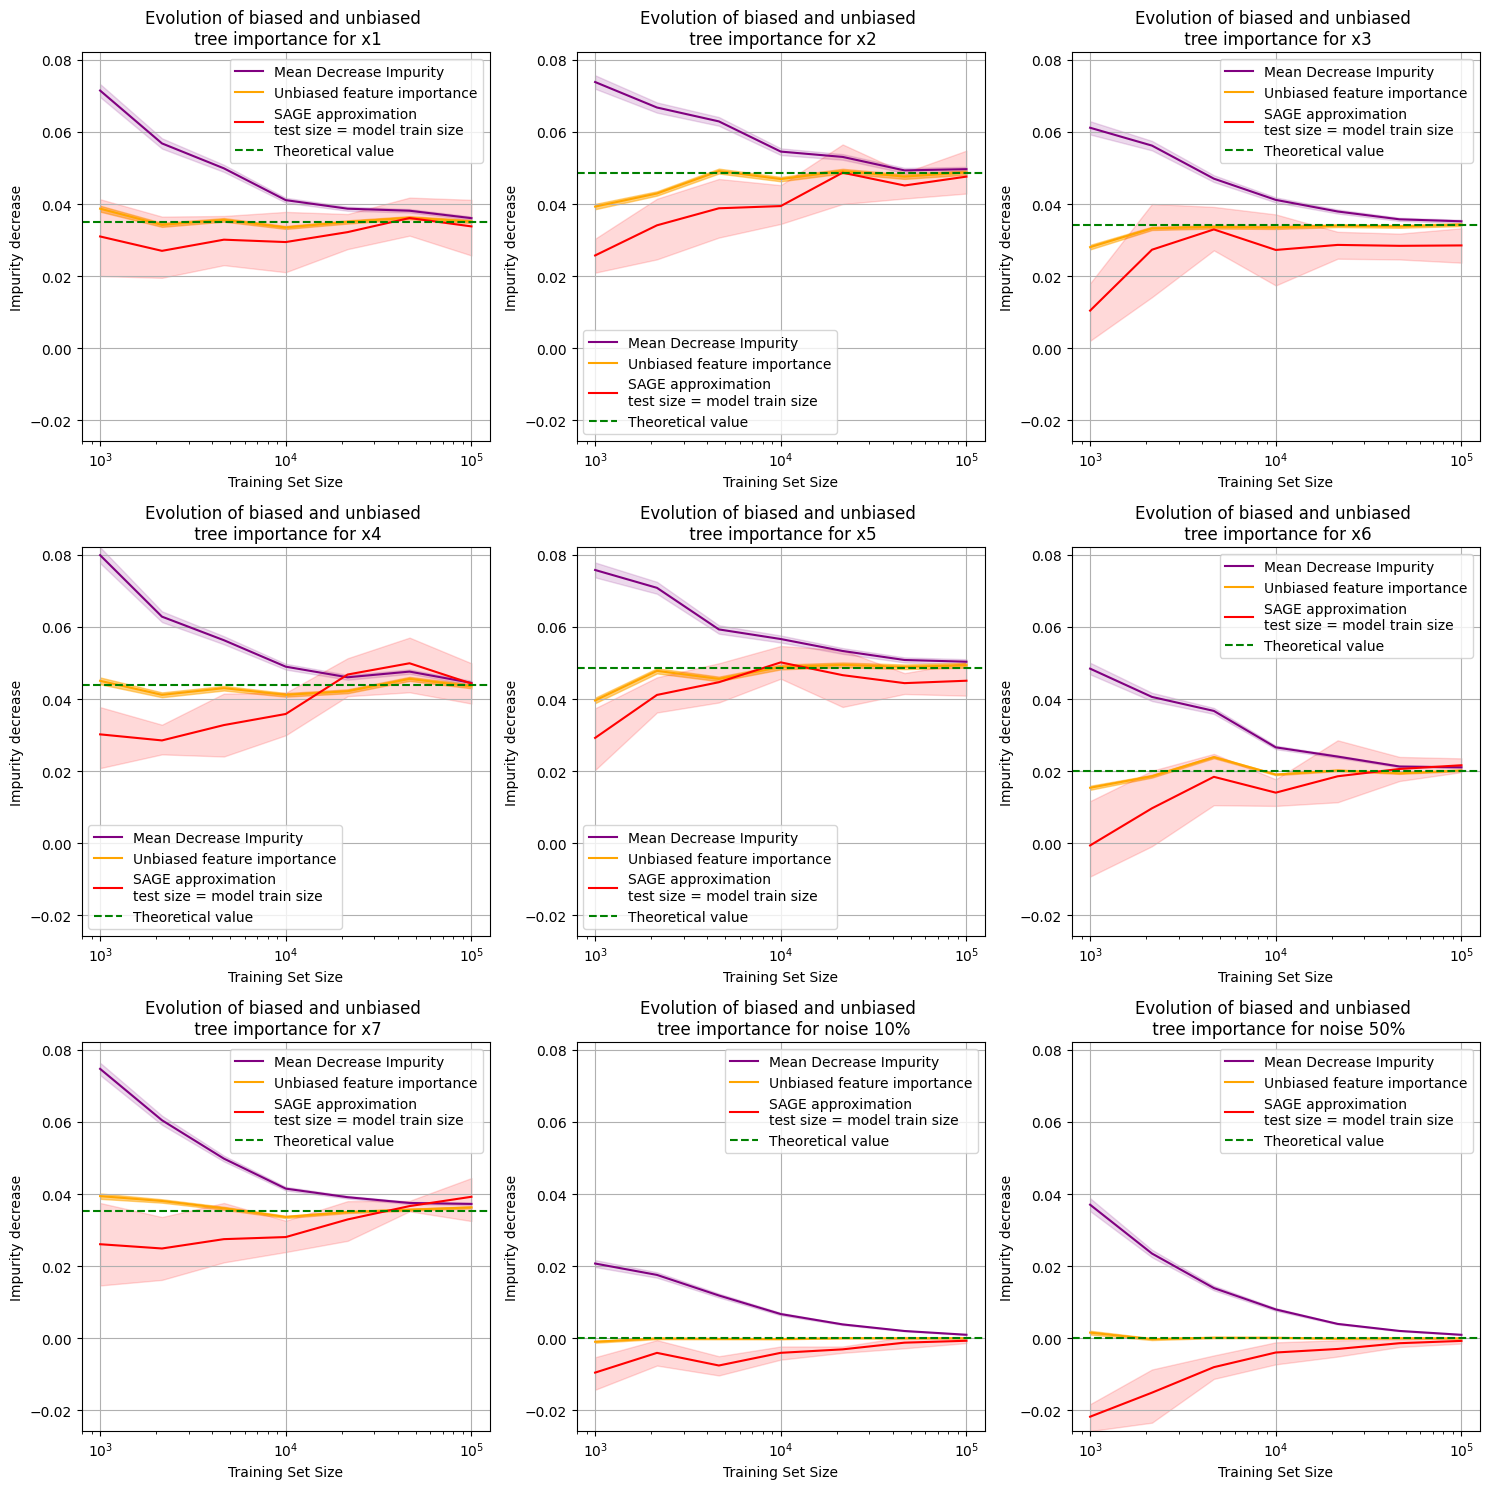

In [8]:
mean_mdi = np.zeros((len(train_sizes_largest), len(feature_names)))
quantiles_mdi = np.zeros((len(train_sizes_largest), len(feature_names), 2))
mean_umdi = np.zeros((len(train_sizes_largest), len(feature_names)))
quantiles_umdi = np.zeros((len(train_sizes_largest), len(feature_names), 2))
mean_sage = np.zeros((len(train_sizes_largest), len(feature_names)))
quantiles_sage = np.zeros((len(train_sizes_largest), len(feature_names), 2))


for train_size_idx in range(len(train_sizes_largest)):
    for feat_idx in range(len(feature_names)):
        mean_mdi[train_size_idx, feat_idx] = mdi_large_res[train_size_idx, :, feat_idx].mean()
        mdi_bootstrap = bootstrap((mdi_large_res[train_size_idx, :, feat_idx],), np.mean, confidence_level=0.95, method="percentile", rng=train_size_idx*len(feature_names) + feat_idx)
        quantiles_mdi[train_size_idx, feat_idx, :] = (mdi_bootstrap.confidence_interval.low, mdi_bootstrap.confidence_interval.high) 
                
        mean_umdi[train_size_idx, feat_idx] = umdi_large_res[train_size_idx, :, feat_idx].mean()
        umdi_bootstrap = bootstrap((umdi_large_res[train_size_idx, :, feat_idx],), np.mean, confidence_level=0.95, method="percentile", rng=train_size_idx*len(feature_names) + feat_idx)
        quantiles_umdi[train_size_idx, feat_idx, :] = (umdi_bootstrap.confidence_interval.low, umdi_bootstrap.confidence_interval.high) 

        mean_sage[train_size_idx, feat_idx] = sage_large_res[train_size_idx, :, feat_idx].mean()
        sage_bootstrap = bootstrap((sage_large_res[train_size_idx, :, feat_idx],), np.mean, confidence_level=0.95, method="percentile", rng=train_size_idx*len(feature_names) + feat_idx)
        quantiles_sage[train_size_idx, feat_idx, :] = (sage_bootstrap.confidence_interval.low, sage_bootstrap.confidence_interval.high)

global_min = np.min([quantiles_mdi, quantiles_umdi, quantiles_sage])
global_max = np.max([quantiles_mdi, quantiles_umdi, quantiles_sage])

# Plot
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()

for i in range(len(feature_names)):
    axs[i].set_ylim(global_min, global_max)
    axs[i].plot(train_sizes_largest, mean_mdi[:, i], label="Mean Decrease Impurity", color='purple')
    axs[i].fill_between(
        train_sizes_largest,
        quantiles_mdi[:, i, 0],
        quantiles_mdi[:, i, 1],
        color='purple',
        alpha=0.15,
    )
    axs[i].plot(train_sizes_largest, mean_umdi[:, i], label="Unbiased feature importance", color='orange')
    axs[i].fill_between(
        train_sizes_largest,
        quantiles_umdi[:, i, 0],
        quantiles_umdi[:, i, 1],
        color='orange',
        alpha=0.5,
    )
    axs[i].plot(train_sizes_largest, mean_sage[:, i], label="SAGE approximation \ntest size = model train size", color='red')
    axs[i].fill_between(
        train_sizes_largest,
        quantiles_sage[:, i, 0],
        quantiles_sage[:, i, 1],
        color='red',
        alpha=0.15,
    )
    axs[i].axhline(theoretical_value[i], ls="--", label="Theoretical value", color="green")

    axs[i].set_xscale('log')
    axs[i].set_xlabel('Training Set Size')
    axs[i].set_ylabel('Impurity decrease')
    axs[i].set_title(f'Evolution of biased and unbiased \n tree importance for {feature_names[i]}')
    axs[i].grid(True)
    axs[i].legend()

plt.tight_layout()
plt.show()


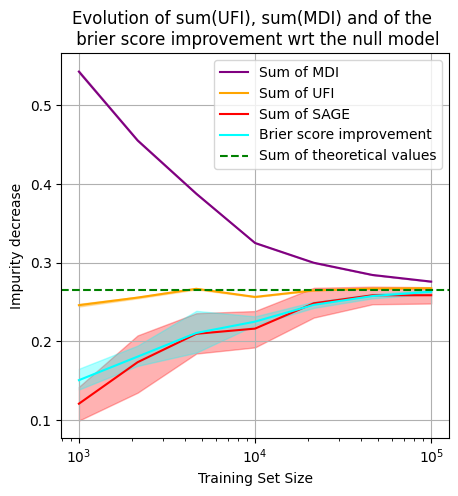

In [9]:
mean_mdi_sum = np.zeros(len(train_sizes_largest))
quantiles_mdi_sum = np.zeros((len(train_sizes_largest), 2))
mean_umdi_sum = np.zeros(len(train_sizes_largest))
quantiles_umdi_sum = np.zeros((len(train_sizes_largest), 2))
mean_sage_sum = np.zeros(len(train_sizes_largest))
quantiles_sage_sum = np.zeros((len(train_sizes_largest), 2))
mean_brier = np.zeros(len(train_sizes_largest))
quantiles_brier = np.zeros((len(train_sizes_largest), 2))

for t_idx in range(len(train_sizes_largest)):
    mean_umdi_sum[t_idx] = umdi_large_res[t_idx, :, :].sum(axis=-1).mean()
    umdi_sum_bootstrap = bootstrap((umdi_large_res[t_idx, :, :].sum(axis=-1),), np.mean, confidence_level=0.95, method="percentile", rng=feat_idx*t_idx)
    quantiles_umdi_sum[t_idx, :] = (umdi_sum_bootstrap.confidence_interval.low, umdi_sum_bootstrap.confidence_interval.high) 

    mean_mdi_sum[t_idx] = mdi_large_res[t_idx, :, :].sum(axis=-1).mean()
    mdi_sum_bootstrap = bootstrap((mdi_large_res[t_idx, :, :].sum(axis=-1),), np.mean, confidence_level=0.95, method="percentile", rng=feat_idx*t_idx)
    quantiles_mdi_sum[t_idx, :] = (mdi_sum_bootstrap.confidence_interval.low, mdi_sum_bootstrap.confidence_interval.high) 

    mean_sage_sum[t_idx] = sage_large_res[t_idx, :, :].sum(axis=-1).mean()
    sage_sum_bootstrap = bootstrap((sage_large_res[t_idx, :, :].sum(axis=-1),), np.mean, confidence_level=0.95, method="percentile", rng=feat_idx*t_idx)
    quantiles_sage_sum[t_idx, :] = (sage_sum_bootstrap.confidence_interval.low, sage_sum_bootstrap.confidence_interval.high)

    mean_brier[t_idx] = brier_score_improvement[t_idx, :].mean()
    brier_bootstrap = bootstrap((brier_score_improvement[t_idx, :],), np.mean, confidence_level=0.95, method="percentile", rng=t_idx)
    quantiles_brier[t_idx, :] = (brier_bootstrap.confidence_interval.low, brier_bootstrap.confidence_interval.high)

fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.plot(train_sizes_largest, mean_mdi_sum, label="Sum of MDI", color='purple')
axs.fill_between(
    train_sizes_largest,
    quantiles_mdi_sum[:, 0],
    quantiles_mdi_sum[:, 1],
    color='purple',
    alpha=0.3,
)
axs.plot(train_sizes_largest, mean_umdi_sum, label="Sum of UFI", color='orange')
axs.fill_between(
    train_sizes_largest,
    quantiles_umdi_sum[:, 0],
    quantiles_umdi_sum[:, 1],
    color='orange',
    alpha=0.3,
)
axs.plot(train_sizes_largest, mean_sage_sum, label="Sum of SAGE", color='red')
axs.fill_between(
    train_sizes_largest,
    quantiles_sage_sum[:, 0],
    quantiles_sage_sum[:, 1],
    color='red',
    alpha=0.3,
)
axs.plot(train_sizes_largest, mean_brier, label="Brier score improvement", color='cyan')
axs.fill_between(
    train_sizes_largest,
    quantiles_brier[:, 0],
    quantiles_brier[:, 1],
    color='cyan',
    alpha=0.3,
)
axs.axhline(theoretical_value.sum(), ls="--", label="Sum of theoretical values", color="green")

axs.set_xscale('log')
axs.set_xlabel('Training Set Size')
axs.set_ylabel('Impurity decrease')
axs.set_title('Evolution of sum(UFI), sum(MDI) and of the \n brier score improvement wrt the null model')
axs.grid(True)
axs.legend()
